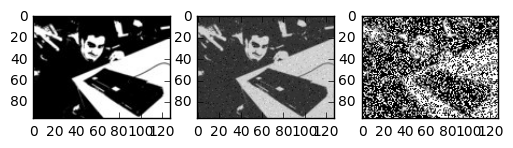

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] = im2[index] + e[index]
    return im2
def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

def heightWidth(image):
    #width is the bigger one, the second one
    return image.shape[0], image.shape[1]

# proportion of pixels to alter
prop = 0.3
varSigma = 0.1
im = imread("../images/manan_grey_resize.jpg")
im = im/255
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')
im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')
im2 = add_saltnpeppar_noise(im,prop)
ax3 = fig.add_subplot(133)
ax3.imshow(im2,cmap='gray')
plt.show()

In [10]:
def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n

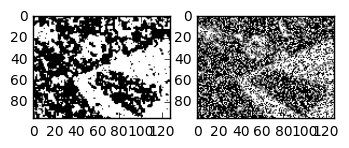

In [12]:
def likeli_single_pos_neg(image, point):
    return np.exp(image[point]), np.exp(-1 * image[point])

def prior_pos_neg(xImage, point):
    expSum_pos = 0
    expSum_neg = 0
    H, W = heightWidth(xImage)
    i, j = point[0], point[1]
    ns = neighbours(i, j, H, W, size=4)
    for neighbour in ns:
        expSum_pos += xImage[neighbour]
        expSum_neg += xImage[neighbour] * -1
    return np.exp(expSum_pos), np.exp(expSum_neg)                


def condProb(image,point,ximage):
    LP, LN = likeli_single_pos_neg(image, point)
    PP, PN = prior_pos_neg(ximage, point)
    numerator = LP * PP
    denominator = LN * PN
    return np.divide(numerator, numerator+denominator)

def GibbsICM(image):
    H, W = heightWidth(image)
    X = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            if (image.item((i, j)) == 1):
                np.put(X, (i, j), 1)
            elif (image.item((i, j)) == 0):
                np.put(X, (i, j), -1)
                
    for i in range(1):
        for i in range(H):
            for j in range(W):
                prob = condProb(image,(i,j),x)
                t = np.random.uniform(0,1)
                if prob > t:
                    np.put(x,(i,j),1)
                else:
                    np.put(x,(i,j),-1)
                    
    return x

def GibbsICM2(image, lim):
    H, W = heightWidth(image)
    X = np.copy(image)
    X[X > 0.5] = 1
    X[X <= 0.5] = -1
    for iteration in range(lim):
        for i in range(H):
            for j in range(W):
                point = (i, j)
                prob = condProb(image, point, X)
                t = np.random.uniform(0, 1)
                if prob > t:
                    X[point] = 1
                else:
                    X[point] = -1
                    
    return X

imFIXED2 = GibbsICM2(im2, 1)

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(imFIXED2,cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')
plt.show()